Data loading

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import regex as re
import pandas as pd
import numpy as np
import math
import os 
import matplotlib.pyplot as plt


file_name = 'cumulative_dataset'
# file_name = 'windowed_30d_dataset'
# file_name = 'windowed_90d_dataset'
# file_name = 'windowed_180d_dataset'
# file_name = 'windowed_365d_dataset'

file_name = "training_dataset_windowed_days_90"
data_path = f'/workspaces/msc_thesis/data/final_data/{file_name}.csv'

df:pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)


print(f'Total entries: {len(df)}.')

print(f'{df.columns=}')

df.describe()

# The number of headers containing metadata; i.e., the stuff that's unusable for inference.
meta_header_count = 4
pr_merged_key = 'PullRequestIsMerged'


Total entries: 1848492.
df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedB

Drop irrelevant fields and perform log-transform on the relevant fields.

In [154]:
removed_fields = [
    "SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator",
    "SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator",

    "SubmitterDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterDependencyEcosystemExperienceIssueSubmissionCount",

    "SubmitterDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperienceIssueDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate

    "SubmitterInversedDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueSubmissionCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate
]

log_transformed_fields = [
    "ControlIntraProjectPullRequestExperienceOfIntegrator",
    "ControlNumberOfCommitsInPullRequest",
    "ControlPullRequestLifeTimeInMinutes",

    "SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator",

    "SubmitterDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount",

    "SubmitterEcosystemExperienceIssueCommentCount",
    "SubmitterEcosystemExperienceIssueSubmissionCount",
    "SubmitterEcosystemExperiencePullRequestCommentCount",
    "SubmitterEcosystemExperiencePullRequestSubmissionCount",

    "SubmitterInversedDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount",
]

binary_fields = [
    "ControlHasHashTagInDescription",
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments",
    "SubmitterIsFirstTimeContributor",
]

print(f'{len(removed_fields)=}')
print(f'{len(binary_fields)=}')
print(f'{len(log_transformed_fields)=}')

new_log_transformed_fields = []
for field in log_transformed_fields:
    new_field_name = f'log10(1 + {field})'
    new_log_transformed_fields.append(new_field_name)
    df[new_field_name] = np.log10(1 + df[field])

print(f'{df.columns=}')
print(f'{df.columns[df.isna().any()].tolist()=}')
df = df.dropna()

len(removed_fields)=15
len(binary_fields)=5
len(log_transformed_fields)=13


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByI

Distribution plots before log-transform.

ControlIntegratedBySameUser
ControlPullRequestLifeTimeInMinutes
ControlPullRequestHasComments
ControlNumberOfCommitsInPullRequest
ControlPullRequestHasCommentByExternalUser
ControlHasHashTagInDescription
PullRequestIsMerged
SubmitterIsFirstTimeContributor
ControlIntraProjectPullRequestExperienceOfIntegrator
ControlIntraProjectPullRequestSuccessRateSubmitter
SubmitterEcosystemExperiencePullRequestSubmissionCount
SubmitterEcosystemExperiencePullRequestSuccessRate
SubmitterEcosystemExperiencePullRequestCommentCount
SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount
SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter
SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter
SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter
SubmitterDependencyEcosystemExperiencePullRequestSubmissi

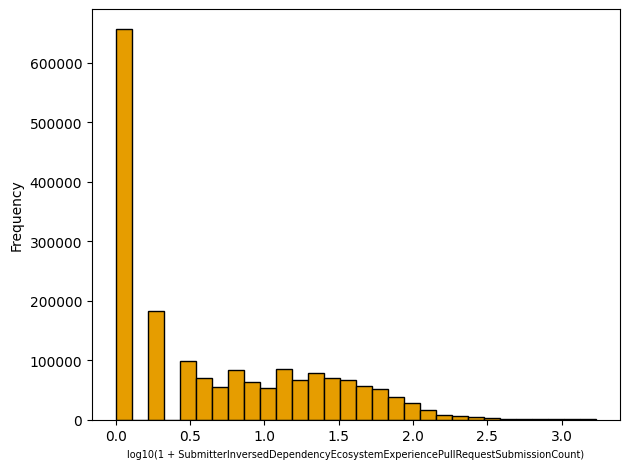

In [155]:
import copy
# shown_fields_without_zeroes = [
#     *log_transformed_fields,
#     *new_log_transformed_fields
# ]
# rx = r'.*(NumberOfCommitsInPullRequest|PullRequestLifeTimeInMinutes).*'
# shown_fields_without_zeroes = set([entry for entry in shown_fields_without_zeroes
#                                    if len(list(re.finditer(rx, entry))) == 0])
# print(f'{shown_fields_without_zeroes=}')

default_plot_settings = {
    'edgecolor': 'black',
    'color': "#e69d00"
}

default_plot_settings_2 = copy.deepcopy(default_plot_settings)
default_plot_settings_2['color'] = "#56b3e9"


def __fix_x_label_fontsize():
    # Adjusts x-label's fontsize to fit the text.
    fig = plt.gcf()
    fig_width = fig.get_figwidth()
    xlabel_fontsize = int(fig_width * 100 / len(column))
    ax = plt.gca()
    orig_fontsize = ax.xaxis.label.get_fontsize()
    ax.xaxis.label.set_fontsize(min(xlabel_fontsize, orig_fontsize))


# Iterate over the columns and generate histograms
for column in df.columns[meta_header_count:]:
    print(column)
    plt.clf()
    entries = df[column]

    if column in binary_fields or column == pr_merged_key:
        entries = df[column].replace({False: 0, True: 1})
        plt.xticks(entries.value_counts().index, ['False', 'True'])
        plt.hist(entries, bins=2, **default_plot_settings)
        plt.ylabel('Frequency')
    # elif column in shown_fields_without_zeroes:
    #     _, bins, _ = plt.hist(entries, bins=30, alpha=1,
    #              label="All Data", **default_plot_settings)
    #     ax:plt.Axes = plt.gca()
    #     ax.set_ylabel("Frequency")
    #     ax.set_xlabel(column)
    #     __fix_x_label_fontsize()

    #     filtered_data = df[column][df[column] != 0]
    #     ax2 = ax.twinx()

    #     ax2.hist(filtered_data, bins, alpha=0.5,
    #              label='Excl. zeroes',**default_plot_settings_2)
    #     ax2.set_ylabel("Frequency (Excl. Zeroes)")
    #     ax2.set_zorder(10)
    #     plt.tight_layout()
    else:
        plt.hist(entries, bins=30, **default_plot_settings)
        plt.ylabel('Frequency')

    plt.xlabel(column)
    __fix_x_label_fontsize()
    plt.tight_layout()

    plt.savefig(
        f"/workspaces/msc_thesis/data/figures/distributions/{column}.png")


Drops the original log-transformed and unusable fields.

In [156]:
df = df.drop(removed_fields, axis=1)
df.drop(log_transformed_fields, axis=1)

,ID,Project Name,PR Number,Closed At,ControlIntegratedBySameUser,ControlPullRequestHasComments,ControlPullRequestHasCommentByExternalUser,ControlHasHashTagInDescription,PullRequestIsMerged,SubmitterIsFirstTimeContributor,...,log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),log10(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),log10(1 + SubmitterDependencyEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount),log10(1 + SubmitterEcosystemExperienceIssueCommentCount),log10(1 + SubmitterEcosystemExperienceIssueSubmissionCount),log10(1 + SubmitterEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterEcosystemExperiencePullRequestSubmissionCount),log10(1 + SubmitterInversedDependencyEcosystemExperiencePullRequestCommentCount),log10(1 + SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount)
0,94665,joshaven/string_score,6,2011-03-17T12:40:33Z,False,False,False,False,True,True,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1,89750,mediaelement/mediaelement,153,2011-03-17T14:02:35Z,False,True,False,False,False,True,...,0.0,0.000000,0.000000,0.00000,0.602060,0.301030,0.00000,0.000000,0.000000,0.00000
2,95263,jquery/jquery-ui,157,2011-03-17T15:28:28Z,False,True,False,False,False,True,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
3,90258,Homebrew/legacy-homebrew,4619,2011-03-17T17:19:21Z,False,True,True,False,False,True,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
4,94674,Homebrew/legacy-homebrew,4713,2011-03-17T17:35:28Z,False,True,True,False,False,True,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848487,355587899,exceljs/exceljs,1058,2020-01-11T23:11:33Z,False,True,False,False,True,True,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1848488,361773395,amplitude/redux-query,168,2020-01-11T23:17:32Z,True,False,False,False,True,False,...,0.0,0.000000,0.845098,0.60206,0.477121,0.301030,0.00000,0.000000,0.845098,0.60206
1848489,361226953,laverdet/isolated-vm,150,2020-01-11T23:19:43Z,False,True,False,True,False,True,...,0.0,0.000000,0.000000,0.00000,0.602060,0.000000,0.00000,0.000000,0.000000,0.00000
1848490,361654021,ioBroker/ioBroker.js-controller,603,2020-01-11T23:26:09Z,False,True,False,False,True,False,...,0.0,0.477121,0.477121,0.30103,2.201397,0.954243,0.69897,0.477121,0.477121,0.30103


Downsamples the majority class to account for class imbalance.

In [157]:
class_counts = df[pr_merged_key].value_counts()

print(f'{class_counts=}')
class_imbalance = max(class_counts) / min(class_counts)
print(f'Class imbalance: {class_imbalance:.03f}.')

# optional.
do_resample = False
if do_resample:
    from sklearn.utils import resample


    majority = df[df.DepPRIsMerged]
    minority = df[df.DepPRIsMerged == False]

    majority = resample(majority, replace=True,
                        n_samples=len(minority), random_state=0)

    df = pd.concat([majority, minority])

    print(f'Resampled size: {len(df)}.')

class_counts=PullRequestIsMerged
True     1422696
False     425787
Name: count, dtype: int64
Class imbalance: 3.341.


Downsamples the dataset in case you set ``sample`` to ``>0``.

In [158]:
sample_size = 0
if sample_size > 0:
    df = df.sample(sample_size)
    print("WARNING: TRAINING WITH SAMPLE!")

Creates train and test data.

In [159]:
train, test = train_test_split(df, test_size=0.2)
print(
    f'Training with {len(train)} entries and testing with {len(test)} entries.')

Training with 1478786 entries and testing with 369697 entries.


Selects predictor features and the dependent feature.

In [160]:
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]
all_labels = df[pr_merged_key]

used_predictors: pd.Index = df.columns[meta_header_count:]
used_predictors = used_predictors.drop(pr_merged_key)

print(f'{len(used_predictors)=}')
print(f'{used_predictors=}')

train_predictors = train[used_predictors]
test_predictors = test[used_predictors]
all_predictors = df[used_predictors]

len(used_predictors)=36
used_predictors=Index(['ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterDependencyEcosystemExperiencePullRequestSuccessRate',
       'SubmitterDependencyEcosystemExperiencePullRequest

## Random Forest

In [161]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
seed = 42
rf = RandomForestRegressor(n_estimators=100, random_state=seed)

rf.fit(train_predictors, train_labels)

predictions = rf.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')

conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

imbalance_weight = list([1.0 if label else class_imbalance for label in test_labels])
f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))


Absolute error: 329899     False
552045     False
1538751    False
1741307    False
1118775    False
           ...  
1326932    False
1818249    False
266953     False
1412704    False
789287     False
Name: PullRequestIsMerged, Length: 369697, dtype: bool
conf=array([[ 54810,  30571],
       [ 15190, 269126]])
f1=0.8210193847615426
              precision    recall  f1-score   support

       False       0.92      0.64      0.76 285286.3219777935
        True       0.72      0.95      0.82  284316.0

    accuracy                           0.79 569602.3219777935
   macro avg       0.82      0.79      0.79 569602.3219777935
weighted avg       0.82      0.79      0.79 569602.3219777935



Generates partial dependence plots.

It's visible that the intra-project experience completely overshadows other factors. 

When exclusing this, you can see that PR acceptance ratio matters as well as whether the PR has comments. 
Lifetime somehow has no effect whatsoever; ditto for the ecosystem PR count. 

36
ControlIntegratedBySameUser
ControlPullRequestLifeTimeInMinutes
ControlPullRequestHasComments
ControlNumberOfCommitsInPullRequest
ControlPullRequestHasCommentByExternalUser
ControlHasHashTagInDescription
SubmitterIsFirstTimeContributor
ControlIntraProjectPullRequestExperienceOfIntegrator
ControlIntraProjectPullRequestSuccessRateSubmitter
SubmitterEcosystemExperiencePullRequestSubmissionCount
SubmitterEcosystemExperiencePullRequestSuccessRate
SubmitterEcosystemExperiencePullRequestCommentCount
SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter
SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount
SubmitterDependencyEcosystemExperiencePullRequestSuccessRate
SubmitterDependencyEcosystemExperiencePullRequestCommentCount
SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount
SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate
SubmitterInversedDependencyEc

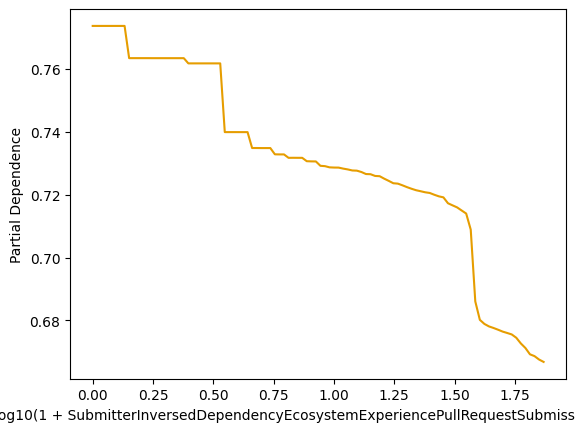

In [162]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# Collective partial dependence plot.
pdd = PartialDependenceDisplay.from_estimator(rf, test_predictors, used_predictors)

fig = plt.gcf()
axs = fig.axes

lines = []
for ax in axs:
    __lines = list([(line.get_xdata(), line.get_ydata()) for line in ax.lines]) 
    lines.extend(__lines)


print(len(lines))

plt.cla()
plt.clf()

base_path = "/workspaces/msc_thesis/data/figures/partial-dependence/"
for (x, y), label in zip(lines, used_predictors):
    print(label)
    plt.clf()

    # Create a line chart
    plt.plot(x, y, linestyle='-', color='#e69d00')

    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Partial Dependence')
    plt.savefig(f'{base_path}/{label}.png')


if not os.path.exists(base_path):
    os.makedirs(base_path)

In [163]:
# Disabled as this takes forever.
# # Individual partial dependence plot.
# PartialDependenceDisplay.from_estimator(
#     rf, test_predictors, used_predictors, kind='individual')

# fig = plt.gcf()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# fig.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.15,
#                     hspace=0.3)


## Logistic Regression

In [164]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_predictors, train_labels)

lr_predictions = lr.predict(test_predictors)

imbalance_weight = [1.0 if label else class_imbalance for label in test_labels]
score = lr.score(test_predictors, test_labels, sample_weight=imbalance_weight)

print(f'{score=}')

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')


conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score=0.6071005590448555
Absolute error: 329899     False
552045     False
1538751    False
1741307    False
1118775    False
           ...  
1326932    False
1818249    False
266953     False
1412704    False
789287     False
Name: PullRequestIsMerged, Length: 369697, dtype: bool
conf=array([[ 54810,  30571],
       [ 15190, 269126]])
f1=0.8210193847615426
              precision    recall  f1-score   support

       False       0.92      0.64      0.76 285286.3219777935
        True       0.72      0.95      0.82  284316.0

    accuracy                           0.79 569602.3219777935
   macro avg       0.82      0.79      0.79 569602.3219777935
weighted avg       0.82      0.79      0.79 569602.3219777935



Calculates corresponding p-values for each feature.

In [165]:
import statsmodels.api as sm

value_mapper = {False: 0, True: 1}
for feature in binary_fields:
    train_predictors[feature] = train_predictors[feature].replace(value_mapper)
    test_predictors[feature] = test_predictors[feature].replace(value_mapper)
    
sm_lr = sm.Logit(train_labels, train_predictors[used_predictors])
result = sm_lr.fit()

print(result.params)

predictions = result.predict(test_predictors[used_predictors])
predictions = [pred >= 0.5 for pred in predictions]

result.pred_table()

print('summary 1:')
result.summary()

print('summary 2:')
result.summary2()


/tmp/ipykernel_7156/1675169009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_predictors[feature] = train_predictors[feature].replace(value_mapper)
/tmp/ipykernel_7156/1675169009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_predictors[feature] = test_predictors[feature].replace(value_mapper)


Optimization terminated successfully.
         Current function value: 0.400799
         Iterations 8


LinAlgError: Singular matrix